# ASTRO 533 - Mid Project 2

**Created:** Nov. 2020   
**Last Edit:** Nov. 2020  

**Author:** Bill Chen  
**Email:** ybchen@umich.edu  

## Load packages and read data

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.table import Table as tb
import astropy.coordinates as coord
import astropy.units as u
from astropy.units import cds
import copy
plt.style.use('bill')

my_YlGnBu = copy.copy(mpl.cm.get_cmap('YlGnBu')) # copy the default cmap
my_YlGnBu.set_bad('w')

my_magma = copy.copy(mpl.cm.get_cmap('magma'))
my_magma.set_bad(my_magma(-1))

nyu_cat = tb.read('lowz_catalog.dr4.fits', format='fits')

In [10]:
print(nyu_cat.keys())

['OBJECT_POSITION', 'ICOMB', 'SECTOR', 'VAGC_SELECT', 'FGOTMAIN', 'MMAX', 'RA', 'DEC', 'RUN', 'RERUN', 'CAMCOL', 'FIELD', 'ID', 'OBJC_ROWC', 'OBJC_COLC', 'PLATE', 'FIBERID', 'MJD', 'PLUG_RA', 'PLUG_DEC', 'QUALITY', 'ABSMAG', 'ABSMAG_IVAR', 'MU50R', 'PSF_FWHM', 'KCORRECT', 'PETROFLUX', 'PETROFLUX_IVAR', 'MODELFLUX', 'MODELFLUX_IVAR', 'EXTINCTION', 'PETROTHETA', 'PETROTH50', 'PETROTH90', 'SERSIC_N', 'SERSIC_TH50', 'SERSIC_FLUX', 'VDISP', 'VDISP_ERR', 'CLASS', 'SUBCLASS', 'VMAX', 'NEDNAME', 'NEDCZ', 'ZHELIO', 'ZLG', 'ZDIST', 'ZDIST_ERR']


In [154]:
Mg = nyu_cat['ABSMAG'][:,1] - 5*np.log10(1) # Mg - 5logh
Mr = nyu_cat['ABSMAG'][:,2] - 5*np.log10(1) # Mr - 5logh
# mur = nyu_cat['MU50R'][:] - 5*np.log10(1)

ind_valid = np.where( (Mg>-30) & (Mr<-10) & (Mr>-30) & (Mg<-10) )[0]
Mg = Mg[ind_valid]
Mr = Mr[ind_valid]

print(len(ind_valid))

49967


## CMD

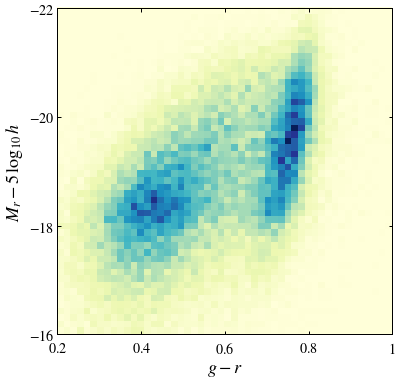

In [153]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist2d(Mg-Mr, Mr, range=[[0.2, 1], [-22, -16]],
          bins = 50, cmap=my_YlGnBu)

ax.set_xlabel(r'$g-r$')
ax.set_ylabel(r'$M_r-5\,\log_{10}\,h$')
ax.set_xlim(0.2, 1)
ax.set_ylim(-16, -22)
ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels([r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'])
ax.set_yticks([-16, -18, -20, -22])
ax.set_yticklabels([r'$-16$', r'$-18$', r'$-20$', r'$-22$'])

plt.savefig('./figures/cmd.pdf')
plt.show()

In [358]:
def V_eff(absmag):
    d = 10**(0.2 * (17.7 - absmag) -5) # in Mpc/h
    d_eff = np.clip(d, 10, 150)
    return (d_eff**3 - 10**3) / (150**3 - 10**3)

def kde_gauss(data, x, h, weights):
    k = sum(np.exp(-((x-data[:,None])/h)**2/2.)*weights[:,None])
    return k/(np.sqrt(2.*np.pi)*h)

def schechter(absmag, alpha, Mstar, bias=1):
    y = np.exp(-10**(-0.4*(absmag-Mstar))) * 10**(-0.4*(absmag-Mstar)*(alpha+1))
    return y * bias / ( np.sum(y) * (23-13)/len(absmag) )

def schechter_doub(absmag, alpha1, alpha2, Mstar, bias=1):
    y = np.exp(-10**(-0.4*(absmag-Mstar))) * ( 1.5*10**(-0.4*(absmag-Mstar)*(alpha1+1)) +\
                                              0.6*10**(-0.4*(absmag-Mstar)*(alpha2+1)) )
    return y * bias / ( np.sum(y) * (23-13)/len(absmag) )

In [289]:
absmag_bins = np.linspace(-23, -13, 50+1)

f_M, absmag_bins = np.histogram(Mr, bins=absmag_bins)
f_M = f_M / V_eff( (absmag_bins[1:]+absmag_bins[:-1])/2 )
f_M = f_M / ( np.sum(f_M) * (23-13)/50 )

absmags = np.linspace(-23, -13, 100)
f_M_kde = kde_gauss(Mr, absmags, h=0.1, weights=1/V_eff(Mr))
f_M_kde = f_M_kde / ( np.sum(f_M_kde) * (23-13)/100 )

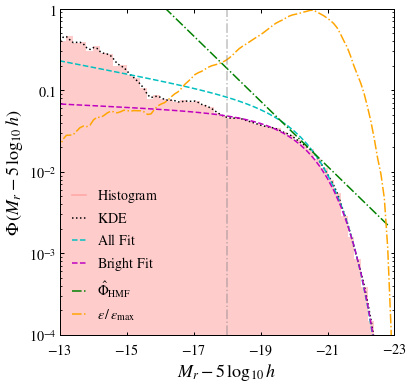

In [392]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot([], [], c='r', ls='-', alpha=0.2, label=r'$\rm Histogram$')
ax.plot(absmags, f_M_kde, c='k', ls=':', label=r'$\rm KDE$')
ax.fill_between(absmag_bins[1:], f_M, step='pre', facecolor='r', alpha=0.2)
ax.plot(absmag_bins[1:], schechter(absmag_bins[1:], -1.2, -20.4, bias=0.9), c='c', ls='--', label=r'$\rm All\ Fit$')
ax.plot(absmag_bins[1:], schechter(absmag_bins[1:], -1.05, -20.4, bias=0.4), c='m', ls='--', label=r'$\rm Bright\ Fit$')
ax.plot(absmag_bins[1:], schechter(absmag_bins[1:], -2, -100, bias=22), c='g', ls='-.', label=r'$\hat{\Phi}_{\rm HMF}$')
ax.plot(absmags, f_M_kde/schechter(absmags, -2, -100, bias=22),
        c='orange', ls='-.', label=r'$\epsilon\,/\,\epsilon_{\rm max}$')
ax.axvline(-18, c='gray', ls='-.', alpha=0.5)

ax.set_xlabel(r'$M_r-5\,\log_{10}\,h$')
ax.set_ylabel(r'$\Phi\,(M_r-5\,\log_{10}\,h)$')
ax.set_yscale('log')
ax.set_xlim(-13, -23)
ax.set_ylim(1e-4, 1)
ax.set_xticks([-13, -15, -17, -19, -21, -23])
ax.set_xticklabels([r'$-13$', r'$-15$', r'$-17$', r'$-19$', r'$-21$', r'$-23$'])
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])
ax.set_yticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$0.1$', r'$1$'])
plt.legend()

plt.savefig('./figures/lf.pdf')
plt.show()